# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns
from sklearn.metrics import accuracy_score
from IPython.display import display
import progressbar
from IPython.core.display import display, HTML

display(HTML('<style>.container { width:95% !important; }</style>'))

%config InlineBackend.figure_format = 'retina'


pd.set_option('max_rows', 35)
pd.set_option('max_columns', None)
plt.style.use('seaborn')
# import progressbar
%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']


# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
miss_vals_content = df_content.isna().sum(axis=0)
miss_vals_user = df.isna().sum(axis=0)

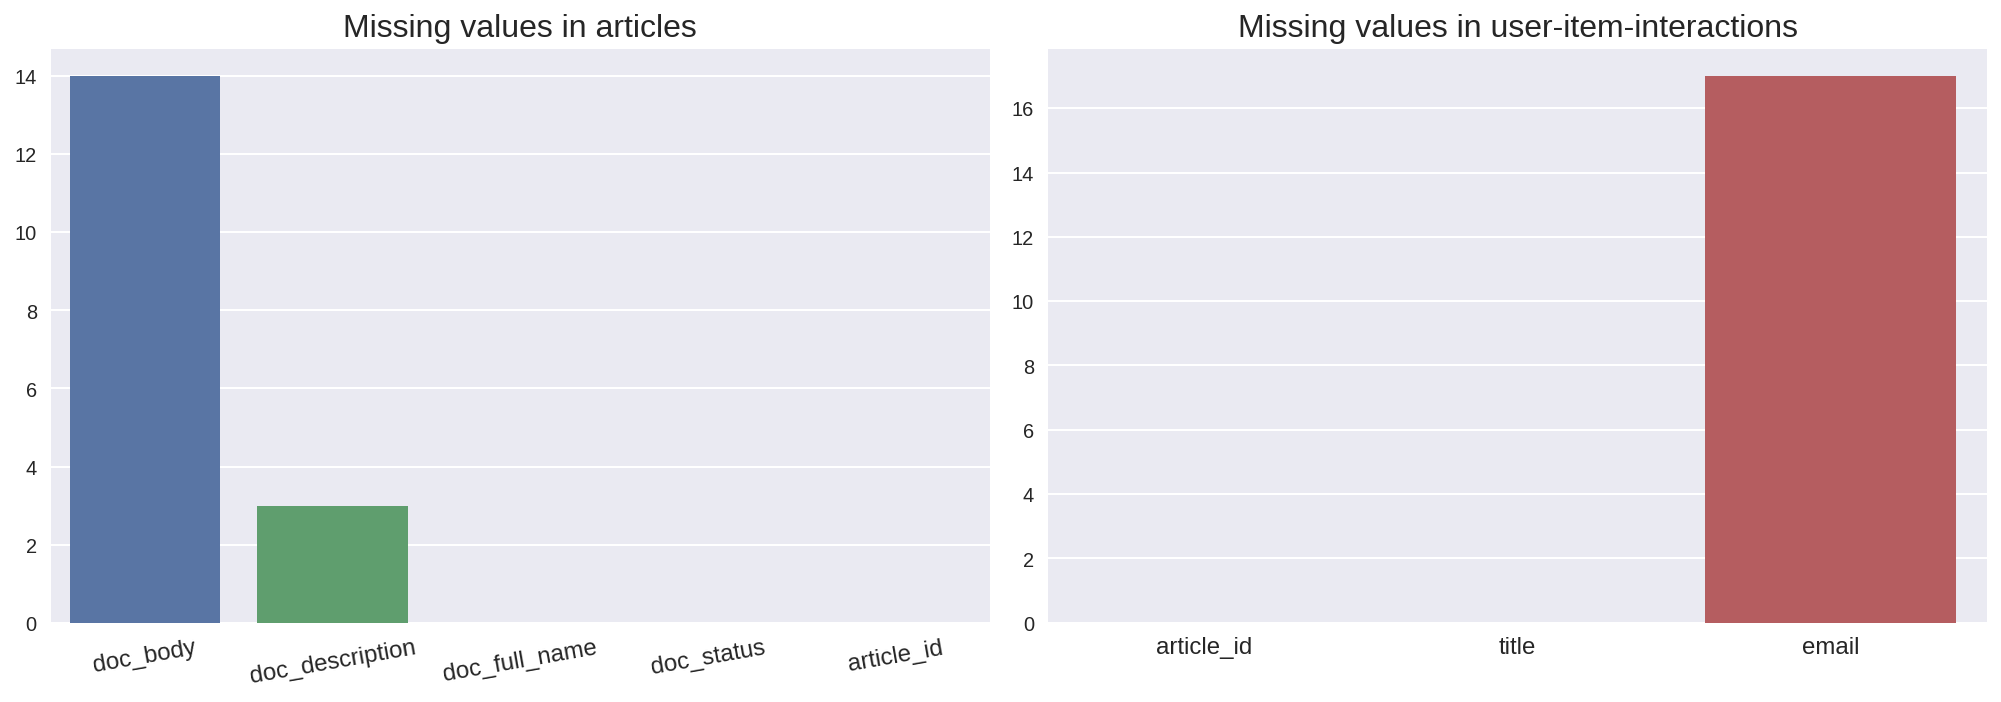

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


    
sns.barplot(miss_vals_content.index, miss_vals_content.values, ax=axes[0])
sns.barplot(miss_vals_user.index, miss_vals_user.values, ax=axes[1])

# for tick in axes[0].xaxis.get_major_ticks():
#         tick.label.set_fontsize(12) 
# for tick in axes[1].xaxis.get_major_ticks():
#         tick.label.set_fontsize(12)

axes[1].set_title('Missing values in user-item-interactions', fontsize=16);
axes[0].set_title('Missing values in articles', fontsize=16);
    
plt.setp(axes[1].xaxis.get_majorticklabels(), fontsize=12)       
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=10, fontsize=12) 


sns.despine()
plt.tight_layout()
plt.show()

In [5]:
df_content.dtypes, df.dtypes
# [becuase ids types not matched we need to change their types] = no change.

(doc_body           object
 doc_description    object
 doc_full_name      object
 doc_status         object
 article_id          int64
 dtype: object, article_id    float64
 title          object
 email          object
 dtype: object)

In [6]:
# df.article_id = df.article_id.astype(np.int64)
# assert df.article_id.dtype == df_content.article_id 

In [7]:
# interactions of users with content
users_interact = df.email.value_counts()
users_interact[:15], print(len(users_interact))

5148


(2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
 77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
 2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
 a37adec71b667b297ed2440a9ff7dad427c7ac85    169
 8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
 f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76    158
 284d0c17905de71e209b376e3309c0b08134f7e2    148
 d9032ff68d0fd45dfd18c0c5f7324619bb55362c    147
 18e7255ee311d4bd78f5993a9f09538e459e3fcc    147
 c60bb0a50c324dad0bffd8809d121246baef372b    145
 276d9d8ca0bf52c780b5a3fc554fa69e74f934a3    145
 56832a697cb6dbce14700fca18cffcced367057f    144
 b2d2c70ed5de62cf8a1d4ded7dd141cfbbdd0388    142
 ceef2a24a2a82031246814b73e029edba51e8ea9    140
 8dc8d7ec2356b1b106eb3d723f3c234e03ab3f1e    137
 Name: email, dtype: int64, None)

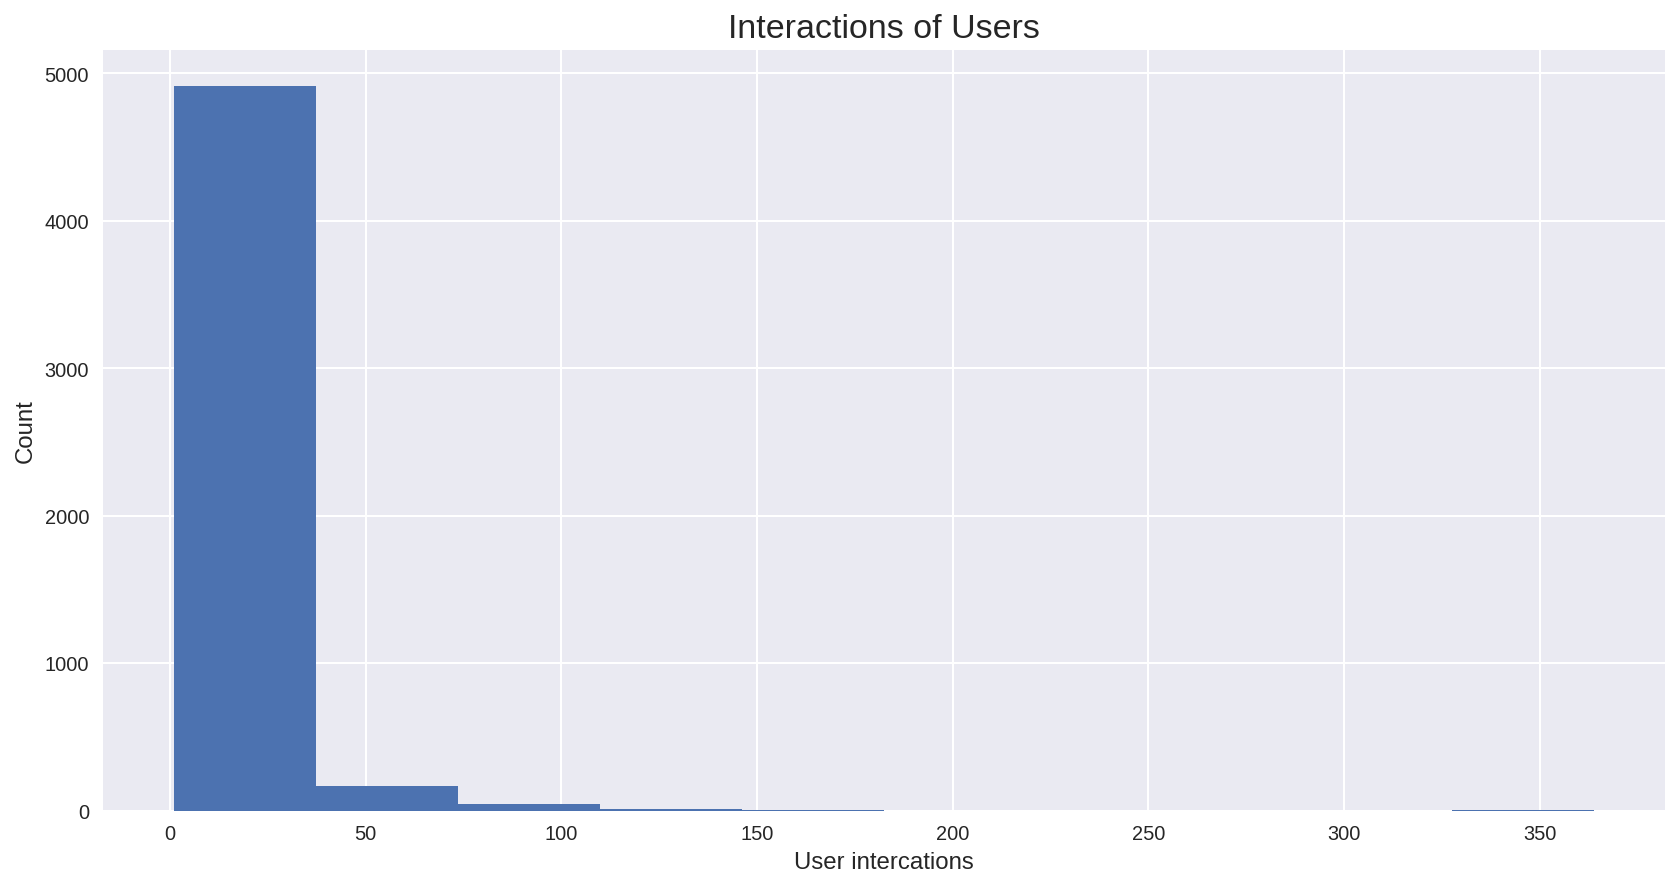

In [8]:
# Distribution of users interactions
fig, ax = plt.subplots(figsize=(14, 7))
plt.title('Interactions of Users', fontsize=17)
plt.hist(users_interact)
plt.xlabel('User intercations', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [9]:
articles_count = df.article_id.value_counts()
articles_count.iloc[:15]

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
1436.0    481
1271.0    473
1398.0    465
43.0      460
1351.0    457
Name: article_id, dtype: int64

In [10]:
cumm_articles_sum = np.cumsum(articles_count.values)
cumm_articles_sum[:15]

array([ 937, 1864, 2535, 3178, 3805, 4419, 4991, 5556, 6068, 6551, 7032,
       7505, 7970, 8430, 8887])

In [11]:
half_user_inter = len(users_interact) / 2
len(cumm_articles_sum[cumm_articles_sum <= half_user_inter]), users_interact.max()

(3, 364)

In [12]:
# Fill in the median and maximum number of user_article interactios below

median_val = len(cumm_articles_sum[cumm_articles_sum <= half_user_inter]) # 50% of individuals interact with [3] number of articles or fewer.
max_views_by_user = users_interact.max() # The maximum number of user-article interactions by any 1 user is [364].

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [13]:
# Find and explore duplicate articles
articles_vals = df_content.article_id.value_counts()
print((articles_vals > 1).sum()) # [5] duplicated articles

5


In [14]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [15]:
unique_articles = articles_count.shape[0] # The number of unique articles that have at least one interaction
total_articles = df_content.shape[0] # The number of unique articles on the IBM platform
unique_users = users_interact.shape[0] # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
most_viewed_article_id = str(articles_count.index[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = articles_count.max() # The most viewed article in the dataset was viewed how many times?

In [17]:
most_viewed_article_id , max_views

('1429.0', 937)

In [18]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [20]:
# article_max_index = df.groupby(['user_id', 'article_id'])['title'].count().unstack().sum().sort_values(ascending=False).index[:20]
# article_max_index.tolist()

In [21]:
# df.columns, df.loc[df.article_id.isin(article_max_index)]['title'].unique().tolist()

In [22]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    user_article = df.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_article_ids = user_article.sum().sort_values(ascending=False).index[:n] # ids of [n] top articles
#     user_article_ids = user_article_ids.tolist()
    
    df_content.drop_duplicates(subset=['article_id'], inplace=True)
    
    top_articles = df.loc[df.article_id.isin(user_article_ids)]['title'].unique().tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    user_article = df.groupby(['user_id', 'article_id'])['title'].count().unstack()
    top_articles = user_article.sum().sort_values(ascending=False).index[:n] 

    return top_articles # Return the top article ids

In [23]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0],
             dtype='float64', name='article_id')


In [24]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [25]:
# df.groupby(['user_id', 'article_id'])['title'].agg(lambda x: 1).unstack().fillna(0)

In [26]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(['user_id', 'article_id'])['title'].agg(lambda x: 1).unstack().fillna(0)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [27]:
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,20.0,25.0,26.0,28.0,29.0,30.0,32.0,33.0,34.0,36.0,39.0,40.0,43.0,48.0,50.0,51.0,53.0,54.0,57.0,58.0,59.0,60.0,62.0,64.0,65.0,68.0,74.0,76.0,77.0,78.0,80.0,81.0,82.0,87.0,89.0,92.0,96.0,98.0,100.0,101.0,102.0,103.0,107.0,108.0,109.0,110.0,111.0,112.0,113.0,115.0,116.0,117.0,120.0,122.0,124.0,125.0,130.0,131.0,132.0,134.0,136.0,138.0,142.0,143.0,145.0,146.0,151.0,152.0,153.0,157.0,158.0,162.0,164.0,173.0,176.0,181.0,183.0,184.0,188.0,189.0,191.0,193.0,194.0,195.0,202.0,205.0,210.0,213.0,215.0,221.0,223.0,224.0,225.0,230.0,232.0,233.0,234.0,236.0,237.0,239.0,240.0,241.0,244.0,250.0,251.0,252.0,253.0,254.0,256.0,258.0,260.0,263.0,266.0,268.0,270.0,273.0,277.0,278.0,283.0,284.0,288.0,291.0,295.0,297.0,298.0,299.0,302.0,303.0,310.0,311.0,313.0,314.0,315.0,316.0,319.0,323.0,324.0,329.0,330.0,336.0,337.0,339.0,346.0,347.0,348.0,349.0,350.0,351.0,352.0,353.0,355.0,356.0,359.0,362.0,363.0,364.0,366.0,367.0,369.0,373.0,375.0,376.0,379.0,381.0,382.0,383.0,384.0,389.0,390.0,395.0,398.0,399.0,400.0,404.0,409.0,411.0,412.0,415.0,416.0,417.0,420.0,422.0,426.0,427.0,428.0,429.0,430.0,437.0,440.0,443.0,444.0,446.0,448.0,455.0,460.0,462.0,463.0,464.0,465.0,468.0,470.0,473.0,474.0,475.0,477.0,479.0,480.0,482.0,485.0,486.0,491.0,492.0,494.0,495.0,499.0,500.0,502.0,504.0,508.0,510.0,515.0,517.0,521.0,522.0,524.0,525.0,528.0,532.0,534.0,542.0,544.0,547.0,553.0,555.0,557.0,559.0,563.0,564.0,566.0,567.0,569.0,575.0,583.0,585.0,586.0,588.0,593.0,599.0,600.0,606.0,607.0,609.0,610.0,616.0,617.0,618.0,622.0,626.0,631.0,632.0,634.0,636.0,641.0,644.0,645.0,647.0,651.0,653.0,655.0,656.0,658.0,659.0,662.0,665.0,667.0,668.0,669.0,670.0,673.0,675.0,677.0,678.0,679.0,680.0,681.0,682.0,684.0,686.0,692.0,693.0,695.0,701.0,705.0,708.0,714.0,715.0,720.0,721.0,722.0,723.0,724.0,725.0,727.0,729.0,730.0,732.0,735.0,740.0,744.0,749.0,751.0,757.0,758.0,759.0,760.0,761.0,763.0,764.0,766.0,768.0,778.0,781.0,782.0,784.0,785.0,788.0,793.0,795.0,800.0,805.0,809.0,812.0,813.0,821.0,825.0,833.0,843.0,844.0,846.0,853.0,855.0,857.0,858.0,861.0,862.0,864.0,865.0,868.0,870.0,871.0,876.0,878.0,880.0,881.0,882.0,884.0,887.0,891.0,892.0,896.0,898.0,903.0,905.0,906.0,910.0,911.0,919.0,926.0,928.0,930.0,932.0,933.0,935.0,936.0,939.0,940.0,941.0,943.0,947.0,948.0,949.0,951.0,952.0,955.0,957.0,958.0,959.0,961.0,962.0,965.0,967.0,968.0,969.0,972.0,973.0,974.0,975.0,977.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0,1000.0,1004.0,1006.0,1008.0,1014.0,1015.0,1016.0,1017.0,1018.0,1024.0,1025.0,1028.0,1030.0,1035.0,1038.0,1042.0,1043.0,1044.0,1047.0,1048.0,1050.0,1051.0,1052.0,1053.0,1054.0,1055.0,1056.0,1057.0,1058.0,1059.0,1060.0,1061.0,1062.0,1063.0,1064.0,1065.0,1066.0,1067.0,1068.0,1069.0,1070.0,1071.0,1072.0,1073.0,1074.0,1075.0,1077.0,1078.0,1079.0,1080.0,1083.0,1084.0,1085.0,1086.0,1089.0,1091.0,1092.0,1097.0,1101.0,1106.0,1108.0,1112.0,1113.0,1114.0,1116.0,1119.0,1120.0,1121.0,1122.0,1123.0,1124.0,1125.0,1127.0,1128.0,1130.0,1134.0,1135.0,1137.0,1138.0,1139.0,1140.0,1141.0,1142.0,1143.0,1144.0,1145.0,1146.0,1147.0,1148.0,1149.0,1150.0,1151.0,1152.0,1153.0,1154.0,1155.0,1156.0,1157.0,1158.0,1159.0,1160.0,1161.0,1162.0,1163.0,1164.0,1165.0,1166.0,1167.0,1168.0,1169.0,1170.0,1171.0,1172.0,1173.0,1174.0,1175.0,1176.0,1177.0,1178.0,1179.0,1180.0,1181.0,1183.0,1184.0,1185.0,1186.0,1187.0,1188.0,1189.0,1190.0,1191.0,1192.0,1195.0,1196.0,1197.0,1198.0,1199.0,1200.0,1202.0,1203.0,1206.0,1208.0,1210.0,1219.0,1221.0,1225.0,1226.0,1227.0,1228.0,1230.0,1232.0,1233.0,1234.0,1235.0,1237.0,1244.0,1247.0,1251.0,1252.0,1253.0,1254.0,1257.0,1260.0,1261.0,1263.0,1266.0,1267.0,1271.0,1273.0,1274.0,1276.0,1277.0,1278.0,1279.0,1280.0,1281.0,1282.0,1283.0,1285.0,1286.0,1289.0,1290.0,1291.0,1292.0,1293.0,1294.0,1295.0,1296.0,1297.0,1298.0,1299.0,1303.0,1304.0,1305.0,1306.0,1307.0,1308.0,1313.0,1314.0,1315.0,1317.0,1318.0,1319.0,1320.0,1321.0,1324.0,1326.0,1328.0,1329.0,1330.0,1331.0,1332.0,1333.0,1334.0,1335.0,1336.0,1337.0,1338.0,1340.0,1343.0,1344.0

In [28]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [29]:
np.array(user_item.loc[34]).shape

(714,)

In [30]:
# np.array(user_item[34]).reshape(-1, 1)
# user = np.array(user_item.loc[34]).reshape(-1, 1)
# other_users_matrix = user_item.drop(34)
# similarity = np.dot(other_users_matrix.values, user)
# similarity_df = pd.DataFrame({'user_id': other_users_matrix.index, 'similarity': similarity.flatten(),
#                                  })
# similarity_df.sort_values(by='similarity', ascending=False, inplace=True)
# similarity_df.user_id[:15].tolist()

In [31]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user = np.array(user_item.loc[user_id]).reshape(-1, 1)
    other_users_matrix = user_item.drop(user_id)
    
    similarity = np.dot(other_users_matrix.values, user)
    
    similarity_df = pd.DataFrame({'user_id': other_users_matrix.index, 'similarity': similarity.flatten(),
                                 })
    # sort by similarity
    similarity_df.sort_values(by='similarity', ascending=False, inplace=True)
    
    # create list of just the ids
    most_similar_users = similarity_df.user_id.tolist()
    # remove the own user's id
    ##  
    return most_similar_users # return a list of the users in order from most to least similar
        

In [32]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [33]:
# user_item.loc[34] == 1

In [34]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
#     print(article_ids)
#     article_ids = [np.int64(x) for x in article_ids]
    article_ids = [float(x) for x in article_ids]
    df_copy = df.drop_duplicates(subset=['article_id'])
    article_names = df_copy.loc[df_copy.article_id.isin(article_ids)]['title'].tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    user = user_item.loc[user_id]
    article_ids = user.loc[user == 1].index.tolist()
    # get_article_names requires ids in str
    article_ids = [str(x) for x in article_ids]
    article_names = get_article_names(article_ids)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    # finding similar users
    article_ids, _ = get_user_articles(user_id)
    similar_users = find_similar_users(user_id)
    
    n_users = len(similar_users)

    recs = []
    # create prograss bar
    cnter = 0
    bar = progressbar.ProgressBar(maxval=n_users+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', 
                                                             progressbar.Percentage()])
    bar.start()

    for user in similar_users:

        # Update the progress bar
        cnter += 1
        bar.update(cnter)

        # Get user articles
        ids, _ = get_user_articles(user)
        article_not_seen = np.setdiff1d(np.array(ids), np.array(article_ids))
        article_not_recs = np.setdiff1d(article_not_seen, np.array(recs))
        # get recommendation
        recs.extend(list(article_not_recs))
        # If there are more than
        if len(recs) > m:
            break

    bar.finish()
    
    recs = recs[:m]
    return recs # return your recommendations for this user_id    

In [35]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

[========================================================================] 100%


['analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: mallorca reviews',
 'analyze facebook data using ibm watson and watson studio',
 'a tensorflow regression model to predict house values']

In [36]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [37]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    # compute similarity of each user to the provided user
    user = np.array(user_item.loc[user_id]).reshape(-1, 1)
    other_users_matrix = user_item.drop(user_id)
    
    similarity = np.dot(other_users_matrix.values, user)
    
    similarity_df = pd.DataFrame({'user_id': other_users_matrix.index, 'similarity': similarity.flatten(),
                                 })
    # articles interactions
    article_interactions = df.groupby('user_id')['article_id'].count()
    df_ar_intr = pd.DataFrame({'user_id': article_interactions.index, 'interactions_count': article_interactions.values})
    
    # joining dataframes
    # sorting merged dataframe
    neighbors_df = similarity_df.merge(df_ar_intr)
    neighbors_df.sort_values(by=['similarity', 'interactions_count'], inplace=True, ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    # finding similar users
    article_ids, _ = get_user_articles(user_id)
    similar_users = get_top_sorted_users(user_id).user_id.tolist()
    
    n_users = len(similar_users)

    recs = []
    # create prograss bar
    cnter = 0
    bar = progressbar.ProgressBar(maxval=n_users+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', 
                                                             progressbar.Percentage()])
    bar.start()

    for user in similar_users:

        # Update the progress bar
        cnter += 1
        bar.update(cnter)

        # Get user articles
        ids, _ = get_user_articles(user)
        article_not_seen = np.setdiff1d(np.array(ids), np.array(article_ids))
        article_not_recs = np.setdiff1d(article_not_seen, np.array(recs))
        # get recommendation
        recs.extend(list(article_not_recs))
        # If there are more than
        if len(recs) > m:
            break

    bar.finish()
    # get recs
    recs, rec_names = recs[:m], get_article_names(recs)
    return recs, rec_names

In [38]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0', '1085.0', '109.0', '1150.0', '1151.0', '1152.0', '1153.0', '1154.0', '1157.0', '1160.0']

The top 10 recommendations for user 20 are the following article names:
['ml optimization using cognitive assistant', 'deploy your python model as a restful api', 'apache spark lab, part 1: basic concepts', 'timeseries data analysis of iot events by using jupyter notebook', 'dsx: hybrid mode', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'ibm watson facebook posts for 2015', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'apache spark lab, part 3: machine learning', 'uci: sms spam collection', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'use apache systemml and spark for machine learning', 'analyze open data sets with spark & pixiedust', 'pixieapp f

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [49]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).user_id.values[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).user_id.values[9] # Find the 10th most similar user to user 131

In [50]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

* Function `get_top_articles` will help in getting us a suggestions for top articles for a new user. Also we could improve the recommendation by asking the user to provide more filtering to the articles he/she likes. Simply by combining `Knowledge-Based Recommendations` with our own `User-User Collaborative Filtering`. Furthermore we could also look into the content of the articles.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [51]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(x) for x in get_top_article_ids(10)] # Your recommendations here



In [52]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [53]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [54]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,1017.0,1018.0,102.0,1024.0,1025.0,1028.0,103.0,1030.0,1035.0,1038.0,1042.0,1043.0,1044.0,1047.0,1048.0,1050.0,1051.0,1052.0,1053.0,1054.0,1055.0,1056.0,1057.0,1058.0,1059.0,1060.0,1061.0,1062.0,1063.0,1064.0,1065.0,1066.0,1067.0,1068.0,1069.0,107.0,1070.0,1071.0,1072.0,1073.0,1074.0,1075.0,1077.0,1078.0,1079.0,108.0,1080.0,1083.0,1084.0,1085.0,1086.0,1089.0,109.0,1091.0,1092.0,1097.0,110.0,1101.0,1106.0,1108.0,111.0,1112.0,1113.0,1114.0,1116.0,1119.0,112.0,1120.0,1121.0,1122.0,1123.0,1124.0,1125.0,1127.0,1128.0,113.0,1130.0,1134.0,1135.0,1137.0,1138.0,1139.0,1140.0,1141.0,1142.0,1143.0,1144.0,1145.0,1146.0,1147.0,1148.0,1149.0,115.0,1150.0,1151.0,1152.0,1153.0,1154.0,1155.0,1156.0,1157.0,1158.0,1159.0,116.0,1160.0,1161.0,1162.0,1163.0,1164.0,1165.0,1166.0,1167.0,1168.0,1169.0,117.0,1170.0,1171.0,1172.0,1173.0,1174.0,1175.0,1176.0,1177.0,1178.0,1179.0,1180.0,1181.0,1183.0,1184.0,1185.0,1186.0,1187.0,1188.0,1189.0,1190.0,1191.0,1192.0,1195.0,1196.0,1197.0,1198.0,1199.0,12.0,120.0,1200.0,1202.0,1203.0,1206.0,1208.0,1210.0,1219.0,122.0,1221.0,1225.0,1226.0,1227.0,1228.0,1230.0,1232.0,1233.0,1234.0,1235.0,1237.0,124.0,1244.0,1247.0,125.0,1251.0,1252.0,1253.0,1254.0,1257.0,1260.0,1261.0,1263.0,1266.0,1267.0,1271.0,1273.0,1274.0,1276.0,1277.0,1278.0,1279.0,1280.0,1281.0,1282.0,1283.0,1285.0,1286.0,1289.0,1290.0,1291.0,1292.0,1293.0,1294.0,1295.0,1296.0,1297.0,1298.0,1299.0,130.0,1303.0,1304.0,1305.0,1306.0,1307.0,1308.0,131.0,1313.0,1314.0,1315.0,1317.0,1318.0,1319.0,132.0,1320.0,1321.0,1324.0,1326.0,1328.0,1329.0,1330.0,1331.0,1332.0,1333.0,1334.0,1335.0,1336.0,1337.0,1338.0,134.0,1340.0,1343.0,1344.0,1346.0,1348.0,1349.0,1350.0,1351.0,1354.0,1355.0,1356.0,1357.0,1358.0,1359.0,136.0,1360.0,1361.0,1362.0,1363.0,1364.0,1365.0,1366.0,1367.0,1368.0,1369.0,1371.0,1372.0,1377.0,1378.0,138.0,1386.0,1387.0,1390.0,1391.0,1393.0,1394.0,1395.0,1396.0,1397.0,1398.0,14.0,1400.0,1401.0,1402.0,1403.0,1404.0,1405.0,1406.0,1407.0,1408.0,1409.0,1410.0,1411.0,1412.0,1414.0,1415.0,1416.0,1418.0,1419.0,142.0,1420.0,1421.0,1422.0,1423.0,1424.0,1425.0,1426.0,1427.0,1428.0,1429.0,143.0,1430.0,1431.0,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0,145.0,146.0,15.0,151.0,152.0,153.0,157.0,158.0,16.0,162.0,164.0,173.0,176.0,18.0,181.0,183.0,184.0,188.0,189.0,191.0,193.0,194.0,195.0,2.0,20.0,202.0,205.0,210.0,213.0,215.0,221.0,223.0,224.0,225.0,230.0,232.0,233.0,234.0,236.0,237.0,239.0,240.0,241.0,244.0,25.0,250.0,251.0,252.0,253.0,254.0,256.0,258.0,26.0,260.0,263.0,266.0,268.0,270.0,273.0,277.0,278.0,28.0,283.0,284.0,288.0,29.0,291.0,295.0,297.0,298.0,299.0,30.0,302.0,303.0,310.0,311.0,313.0,314.0,315.0,316.0,319.0,32.0,323.0,324.0,329.0,33.0,330.0,336.0,337.0,339.0,34.0,346.0,347.0,348.0,349.0,350.0,351.0,352.0,353.0,355.0,356.0,359.0,36.0,362.0,363.0,364.0,366.0,367.0,369.0,373.0,375.0,376.0,379.0,381.0,382.0,383.0,384.0,389.0,39.0,390.0,395.0,398.0,399.0,4.0,40.0,400.0,404.0,409.0,411.0,412.0,415.0,416.0,417.0,420.0,422.0,426.0,427.0,428.0,429.0,43.0,430.0,437.0,440.0,443.0,444.0,446.0,448.0,455.0,460.0,462.0,463.0,464.0,465.0,468.0,470.0,473.0,474.0,475.0,477.0,479.0,48.0,480.0,482.0,485.0,486.0,491.0,492.0,494.0,495.0,499.0,50.0,500.0,502.0,504.0,508.0,51.0,510.0,515.0,517.0,521.0,522.0,524.0,525.0,528.0,53.0,532.0,534.0,54.0,542.0,544.0,547.0,553.0,555.0,557.0,559.0,563.0,564.0,566.0,567.0,569.0,57.0,575.0,58.0,583.0,585.0,586.0,588.0,59.0,593.0,599.0,60.0,600.0,606.0,607.0,609.0,610.0,616.0,617.0,618.0,62.0,622.0,626.0,631.0,632.0,634.0,636.0,64.0,641.0,644.0,645.0,647.0,65.0,651.0,653.0,655.0,656.0,658.0,659.0,662.0,665.0,667.0,668.0,669.0,670.0,673.0,675.0,677.0,678.0,679.0,68.0,680.0,681.0,682.0,684.0,686.0,692.0,693.0,695.0,701.0,705.0,708.0,714.0,715.0,720.0,721.0,722.0,723.0,724.0,725.0,727.0,729.0,730.0,732.0,735.0,74.0,740.0,744.0,749.0,751.0,757.0,758.0,759.0,76.0,760.0,761.0,763.0,764.0,766.0,768.0,77.0,778.0,78.0,781.0,782.0,784.0,

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [55]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)
s.shape, u.shape, vt.shape # use the built in to get the three matrices

((714,), (5149, 5149), (714, 714))

**Provide your response here.**
In the lessons the user_item_matrix contains the rating,
Here we only have if the user viewed the article or not

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

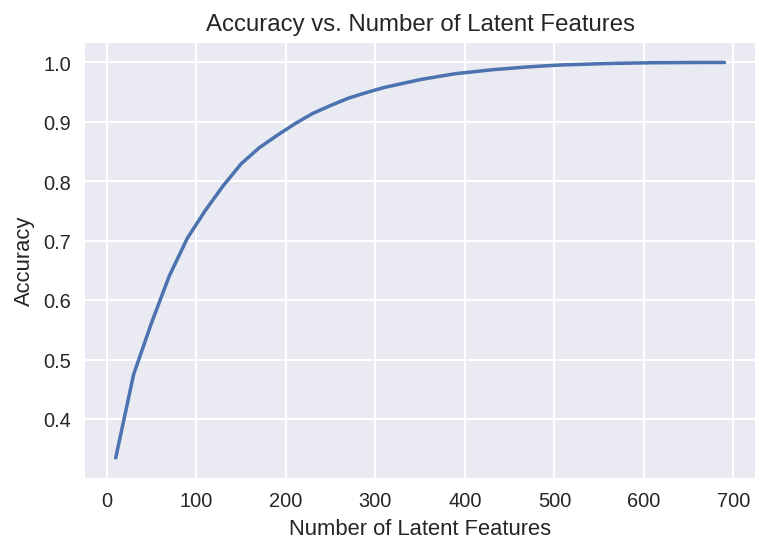

In [56]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [57]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    # getting user_by_article matrix for training, testing
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index.values.tolist()
    test_arts = user_item_test.columns.values.tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [58]:
user_item_train.shape, user_item_test.shape, len(np.setdiff1d(user_item_test.index, user_item_train.index)), len(np.setdiff1d(user_item_test.columns, user_item_train.columns))

((4487, 714), (682, 574), 662, 0)

In [59]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

KeyError: 'How many movies can we make predictions for in the test set?'

 **for some reason im getting a key error**

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [60]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [65]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
test_idx = user_item_test.index # rows matching the test data
rows_idxs = user_item_train.index.isin(test_idx)
u_test = u_train[rows_idxs, :]

test_col = user_item_test.columns # Columns matching the test data
cols_idxs = user_item_train.columns.isin(test_col)
vt_test = vt_train[:, cols_idxs]

# test data
train_idx = user_item_train.index
rows_indx_test = user_item_test.index.isin(train_idx)
user_item_test_subset = user_item_test.loc[rows_indx_test]

In [ ]:
num_latent_feats = np.arange(10,700+10,20)

sum_errs, traing_errors, test_errors = [], [], []
for k in num_latent_feats:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    sum_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(user_item_test_subset)))/(user_item_test_subset.shape[0]*user_item_test_subset.shape[1])))
    # prediction accuracy
    traing_errors.append(accuracy_score(user_item_train.values.flatten(), user_item_train_preds.flatten()))
    test_errors.append(accuracy_score(user_item_test_subset.values.flatten(), user_item_test_preds.flatten()))
    

fig, _ = plt.subplots(figsize=(8, 7))
plt.plot(num_latent_feats, sum_errs, label='Sum of Errors')
plt.plot(num_latent_feats, traing_errors, label='Train')
plt.plot(num_latent_feats, test_errors, label='Test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

We can notice that the model is overfitting the training set as its accuracy increases the testing however decreases. The more latent features we add the higher the training accuracy increaes but the trade-off is the testing decreases. The relationship between latent features and testing accuracy is negative meanning we can't increase one with reducing the other. Cross validation might solve this problem while allowing the model to see subsets of the data.and ways to imporve the recommendation is by using collaborative filtering or content based recommendation. We could do A/B for users who uses our recomendation engine and another set of users who use different method for recomedation we could the interaction rate between these groups. comparing the interaction rate for the our recommendation if its increaes views is significant. Then our recommendation is works 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])